# Import libraries

In [1]:
from datetime import datetime as dt

import re
import xarray as xr
import pathlib as pl
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
%matplotlib notebook
%run ./utils.ipynb

## Parameters

In [3]:
# Temporal filters
YEAR_MONTH = "202011"

# Spatial filters
MIN_LATITUDE, MAX_LATITUDE = 25, 50
MIN_LONGITUDE, MAX_LONGITUDE = 310, 360 

# Parameters
DATA_DIR = pl.Path.cwd().resolve().parent / "data" / "remss"

## Load and filter data

In [4]:
# Load and filter data
def load_and_filter_data(dirname: pl.Path) -> xr.Dataset:
    """Load data from a YEAR_MONTH directory"""
    wind_data = None
    for filepath in dirname.iterdir():
        if not bool(re.match(r"^CCMP.*\.nc$", filepath.name)):
            continue
        # Load
        new_data = xr.open_dataset(filepath)
        # Filter
        new_data = new_data.sel(
            longitude=slice(MIN_LONGITUDE, MAX_LONGITUDE), 
            latitude=slice(MIN_LATITUDE, MAX_LATITUDE),
        )
        # Concat
        wind_data = xr.concat([wind_data, new_data], dim="time") if wind_data is not None else new_data
    # Sort
    wind_data = wind_data.sortby("time")
    return wind_data

%time wind_data = load_and_filter_data(dirname=DATA_DIR / YEAR_MONTH)
wind_data

CPU times: user 779 ms, sys: 740 ms, total: 1.52 s
Wall time: 1.55 s


<xarray.Dataset>
Dimensions:    (longitude: 200, latitude: 100, time: 120)
Coordinates:
  * longitude  (longitude) float32 310.1 310.4 310.6 310.9 ... 359.4 359.6 359.9
  * latitude   (latitude) float32 25.12 25.38 25.62 25.88 ... 49.38 49.62 49.88
  * time       (time) datetime64[ns] 2020-11-01 ... 2020-11-30T18:00:00
Data variables:
    uwnd       (time, latitude, longitude) float32 -4.797 -4.611 ... 10.49 10.61
    vwnd       (time, latitude, longitude) float32 -1.489 -1.077 ... -3.368
    nobs       (time, latitude, longitude) float32 1.0 1.0 1.0 ... 0.0 0.0 0.0
Attributes: (12/36)
    contact:                    Remote Sensing Systems, support@remss.com
    Conventions:                CF-1.6
    data_structure:             grid
    title:                      RSS CCMP_RT V2.1 derived surface winds (Level...
    history:                    20201209T125739ZZ - netCDF generated from ori...
    description:                RSS VAM 6-hour analyses starting from the NCE...
    ...                         ...
    contributor_name:           Carl Mears, Joel Scott, Frank Wentz, Ross Hof...
    contributor_role:           Co-Investigator, Software Engineer, Project L...
    processing_level:           L3.0
    keywords:                   surface winds, ocean winds, wind speed/wind d...
    keywords_vocabulary:        GCMD Science Keywords
    references:                 Mears et al., Journal of Geophysical Research...

In [5]:
PLOT = False

if PLOT:
    def get_tmp_data(i):
        return wind_data.isel(time=i)
    
    initial_wind = wind_data.isel(time=0)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.coastlines()
    
    initial_ws = np.sqrt(initial_wind["uwnd"]**2 + initial_wind["vwnd"]**2) * 3600 / 1852
    contour = plt.contourf(initial_wind["longitude"], initial_wind["latitude"], initial_ws, transform=ccrs.PlateCarree())
    plt.colorbar()
    quiver = plt.quiver(initial_wind["longitude"], initial_wind["latitude"], initial_wind["uwnd"], initial_wind["vwnd"])
    
    def plot_wind_time_evolution(i_step):
        global contour
        global quiver
        tmp_wind_data = get_tmp_data(i_step)
        for con in contour.collections:
            con.remove()
        new_ws = np.sqrt(tmp_wind_data["uwnd"]**2 + tmp_wind_data["vwnd"]**2) * 3600 / 1852
        contour = plt.contourf(tmp_wind_data["longitude"], tmp_wind_data["latitude"], new_ws, transform=ccrs.PlateCarree())
        quiver = plt.quiver(tmp_wind_data["longitude"], tmp_wind_data["latitude"], tmp_wind_data["uwnd"], tmp_wind_data["vwnd"])
        plt.title(f"Historical wind at {tmp_wind_data['time'].values}", pad=-25)
        return quiver, contour
    
    anim = animation.FuncAnimation(
        fig, 
        plot_wind_time_evolution, 
        interval=400, 
        blit=False, 
    )
    fig.tight_layout()
    plt.show()

## Process vortex recognition

In [10]:
time_to_vortex = {}
for timestamp in tqdm(wind_data.time.values):
    # Filter wind data on timestamp
    tmp_wind_data = wind_data.sel(time=slice(timestamp, timestamp)).mean("time")
    # Identify vortexes
    vortexes = identify_vortex_parameters(
        tmp_wind_data["longitude"], 
        tmp_wind_data["latitude"], 
        tmp_wind_data["uwnd"], 
        tmp_wind_data["vwnd"], 
        center_method="convolution", 
        n_radius_iterations=20,
        kernel_size_center=4,
    )
    time_to_vortex[timestamp] = vortexes

100%|██████████████████████████████████████████████████████████████████████████████████| 120/120 [00:07<00:00, 16.76it/s]


<IPython.core.display.Javascript object>


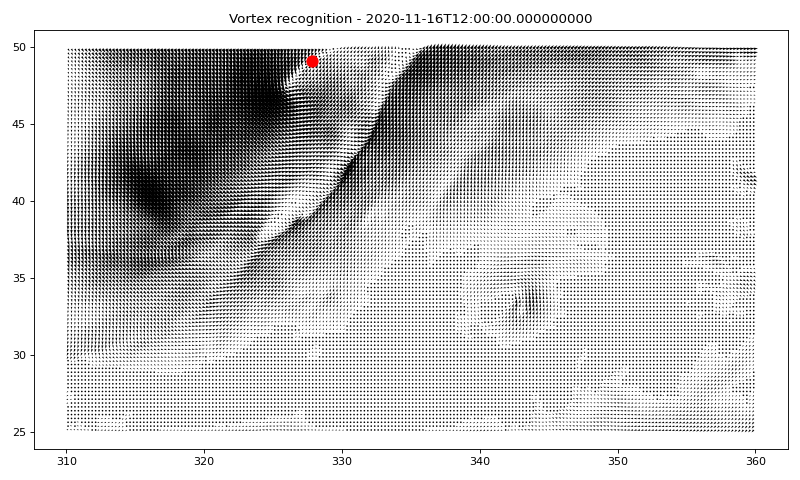

In [13]:
PLOT = True

if PLOT:
    def plot_vortexes(tmp_wind_data, vortexes):
        lon, lat = tmp_wind_data["longitude"], tmp_wind_data["latitude"]
        u, v = tmp_wind_data["uwnd"], tmp_wind_data["vwnd"]
        timestamp = tmp_wind_data.time.values
        lon_step, lat_step = (lon[1].values - lon[0].values), (lat[1].values - lat[0].values)

        lon_centers = [vortex.center.x for vortex in vortexes]
        lat_centers = [vortex.center.y for vortex in vortexes]
        #plot_lon_radius, plot_lat_radius = [], []
        #for vortex in vortexes:
        #    plot_lon_radius.append([
        #        np.maximum(np.min(lon), np.minimum(np.max(lon), vortex.center.x + k * lon_step)) for k in range(-vortex.radius.x, vortex.radius.x + 1)
        #    ])
        #    plot_lat_radius.append([
        #        np.maximum(np.min(lat), np.minimum(np.max(lat), vortex.center.y + k * lat_step)) for k in range(-vortex.radius.y, vortex.radius.y + 1)
        #    ])

        # Plot vortexes
        quiver = plt.quiver(lon, lat, u, v, units="xy")
        scatters = plt.scatter(lon_centers, lat_centers, color="red", s=100)
        #for (vortex, plot_lon, plot_lat) in zip(vortexes, plot_lon_radius, plot_lat_radius):
        #    plt.plot(plot_lon, [vortex.center.y] * len(plot_lon), color="blue", linewidth=4)
        #    plt.plot([vortex.center.x] * len(plot_lat), plot_lat, color="blue", linewidth=4)
        plt.title(f"Vortex recognition - {timestamp}")
        return quiver, scatters
    
    def get_tmp_data(i):
        return wind_data.isel(time=i)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    initial_wind = wind_data.isel(time=0)
    initial_vortexes = time_to_vortex.get(initial_wind.time.values, [])
    quiver, scatters = plot_vortexes(initial_wind, initial_vortexes)

    def plot_vortexes_evolution(i_step):
        tmp_wind_data = get_tmp_data(i_step)
        tmp_vortexes = time_to_vortex.get(tmp_wind_data.time.values, [])
        ax.clear()
        quiver, scatters = plot_vortexes(tmp_wind_data, tmp_vortexes)
        return quiver, scatters
    
    anim = animation.FuncAnimation(
        fig,
        plot_vortexes_evolution, 
        interval=500,
        blit=False,
    )
    fig.tight_layout()
    plt.show()

    